In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import timedelta

# p_project = Path(__file__).parents[2]
p_project = Path(os.getcwd()).parents[1]
path_m4 = p_project/'data/ehr/mimic4'

In [2]:
lab_df = pd.read_csv(path_m4/'processed/lab_processed.csv')[
    ['subject_id', 'hadm_id', 'charttime', 'valuenum', 'label']]
inputs_df = pd.read_csv(path_m4/'processed/inputs_processed.csv')[
    ['subject_id', 'hadm_id', 'charttime', 'amount', 'label']]
outputs_df = pd.read_csv(path_m4/'processed/outputs_processed.csv')[
    ['subject_id', 'hadm_id', 'charttime', 'value', 'label']]
presc_df = pd.read_csv(path_m4/'processed/prescriptions_processed.csv')[
    ['subject_id', 'hadm_id', 'charttime', 'dose_val_rx', 'drug']]

# Change the name of amount. Valuenum for every table
inputs_df['valuenum'] = inputs_df['amount']
inputs_df = inputs_df.drop(columns=['amount']).copy()

outputs_df['valuenum'] = outputs_df['value']
outputs_df = outputs_df.drop(columns=['value']).copy()

presc_df['valuenum'] = presc_df['dose_val_rx']
presc_df = presc_df.drop(columns=['dose_val_rx']).copy()
presc_df['label'] = presc_df['drug']
presc_df = presc_df.drop(columns=['drug']).copy()

# Tag to distinguish between lab and inputs events
inputs_df['Origin'] = 'Inputs'
lab_df['Origin'] = 'Lab'
outputs_df['Origin'] = 'Outputs'
presc_df['Origin'] = 'Prescriptions'

merged_df = pd.concat((inputs_df, lab_df, outputs_df, presc_df)).reset_index()

# Check that all labels have different names.
assert(merged_df['label'].nunique() == (inputs_df['label'].nunique(
)+lab_df['label'].nunique()+outputs_df['label'].nunique()+presc_df['label'].nunique()))

/tmp/ipykernel_1005058/511566662.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  inputs_df = pd.read_csv(path_m4/'processed/inputs_processed.csv')[
/tmp/ipykernel_1005058/511566662.py:7: DtypeWarning: Columns (12,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  presc_df = pd.read_csv(path_m4/'processed/prescriptions_processed.csv')[


In [ ]:
# set the timestamp as the time delta between the first chart time for each admission
merged_df['charttime'] = pd.to_datetime(
    merged_df['charttime'], format='%Y-%m-%d %H:%M:%S')
ref_time = merged_df.groupby('hadm_id')['charttime'].min()
merged_df_1 = pd.merge(ref_time.to_frame(name='ref_time'),
                       merged_df, left_index=True, right_on='hadm_id')
merged_df_1['time_stamp'] = merged_df_1['charttime']-merged_df_1['ref_time']
assert(len(merged_df_1.loc[merged_df_1['time_stamp']
       < timedelta(hours=0)].index) == 0)

# Create a label code (int) for the labels.
label_dict = dict(zip(list(merged_df_1['label'].unique()), range(
    len(list(merged_df_1['label'].unique())))))
merged_df_1['label_code'] = merged_df_1['label'].map(label_dict)

label_dict_df = pd.Series(merged_df_1['label'].unique()).reset_index()
label_dict_df.columns = ['index', 'label']
label_dict_df['label_code'] = label_dict_df['label'].map(label_dict)
label_dict_df.drop(columns=['index'], inplace=True)
label_dict_df.to_csv(path_m4/'processed/variable_name_dict.csv')

merged_df_short = merged_df_1[['hadm_id', 'valuenum', 'time_stamp', 'label_code']].rename(
    columns={'hadm_id': 'ID', 'time_stamp': 'Time'})

# select patients who have records in both the first 24 hours and the second 24 hours
ids_before_24 = merged_df_short.loc[(
    merged_df_short['Time'] < timedelta(hours=24))]['ID'].unique()

ids_after_24 = merged_df_short.loc[(merged_df_short['Time'] >= timedelta(hours=24)) &
                                   (merged_df_short['Time'] < timedelta(hours=48))]['ID'].unique()

merged_df_short = merged_df_short.loc[merged_df_short['ID'].isin(
    set(ids_before_24) & set(ids_after_24))]

# select 48h records
merged_df_short = merged_df_short.loc[merged_df_short['Time'] < timedelta(
    hours=48)]

# The sampling interval is 1 minute
merged_df_short['Time'] = merged_df_short['Time'].dt.total_seconds().div(
    60).astype(int)
assert(len(merged_df_short.loc[merged_df_short['Time'] > 2880].index) == 0)

value_df = pd.pivot_table(merged_df_short, values='valuenum', index=[
                          'ID', 'Time'], columns=['label_code'], aggfunc=np.max)
mask_df = value_df.notna()

d_values = {}
d_masks = {}
for i in value_df.columns:
    d_values[i] = "Value_" + str(i)
    d_masks[i] = "Mask_" + str(i)

value_df.rename(columns=d_values, inplace=True)
mask_df.rename(columns=d_masks, inplace=True)

value_df.fillna(0, inplace=True)
mask_df = mask_df.astype(int)

complete_df = pd.concat((value_df, mask_df), axis=1).reset_index()

complete_df['ID'] = complete_df['ID'].astype(int)

complete_df.sort_values(["ID", "Time"], inplace=True)

complete_df.to_csv(
    path_m4/'processed/mimic4_full_dataset.csv', index=False)


In [3]:
complete_df = pd.read_csv(path_m4/'processed/mimic4_full_dataset.csv', index_col=0)

In [4]:
complete_df.head()

,Time,Value_0,Value_1,Value_2,Value_3,Value_4,Value_5,Value_6,Value_7,Value_8,...,Mask_86,Mask_87,Mask_88,Mask_89,Mask_90,Mask_91,Mask_92,Mask_93,Mask_94,Mask_95
ID,,,,,,,,,,,,,,,,,,,,,
20000147,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
20000147,578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
20000147,599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
20000147,693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
20000147,720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
complete_df.shape

(5400045, 193)

In [ ]:
# Calculate the standard deviation of elements along the axis 0. 
# Turn elements out of 5 times of the standard deviation into 0.
def remove_outlier(data, mask, threshold=5):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    mask_outlier = abs(data - mean) > threshold * std
    data = np.where(mask_outlier, 0, data)
    mask = np.where(mask_outlier, 0, mask)
    return data, mask

value_cols = []
mask_cols = []
for col in complete_df.columns:
    value_cols.append(col.startswith("Value"))
    mask_cols.append(col.startswith("Mask"))

value = complete_df.loc[:, value_cols].values
mask = complete_df.loc[:, mask_cols].values
value_new, mask_new = remove_outlier(value, mask)
complete_df.loc[:, value_cols] = value_new
complete_df.loc[:, mask_cols] = mask_new
complete_df = complete_df.loc[complete_df.loc[:, mask_cols].sum(axis=1) > 0]

complete_df.shape

In [32]:
## Exclude variables with less than 1000 records
# Filter out the columns based on the sum of the mask columns
drop_mask_cols = complete_df.loc[:, mask_cols].sum(axis=0) < 1000
# select the index name if the indicator is True
names_drop_mask_cols = drop_mask_cols.index[drop_mask_cols].to_list()
names_drop_value_cols = [name.replace("Mask", "Value")
                            for name in names_drop_mask_cols]
# drop the columns
complete_df.drop(columns=names_drop_mask_cols + names_drop_value_cols, inplace=True)
complete_df.shape

(4691240, 143)

In [33]:
Mask_df = complete_df.filter(regex='^(?!.*Value).*', axis=1) # Exclude columns with Value in the name

In [34]:
Mask_df.head()

,Time,Mask_0,Mask_1,Mask_2,Mask_3,Mask_4,Mask_6,Mask_9,Mask_10,Mask_11,...,Mask_79,Mask_80,Mask_81,Mask_82,Mask_84,Mask_86,Mask_87,Mask_89,Mask_91,Mask_93
ID,,,,,,,,,,,,,,,,,,,,,
20000147,578,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20000147,599,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20000147,693,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20000147,720,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20000147,742,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

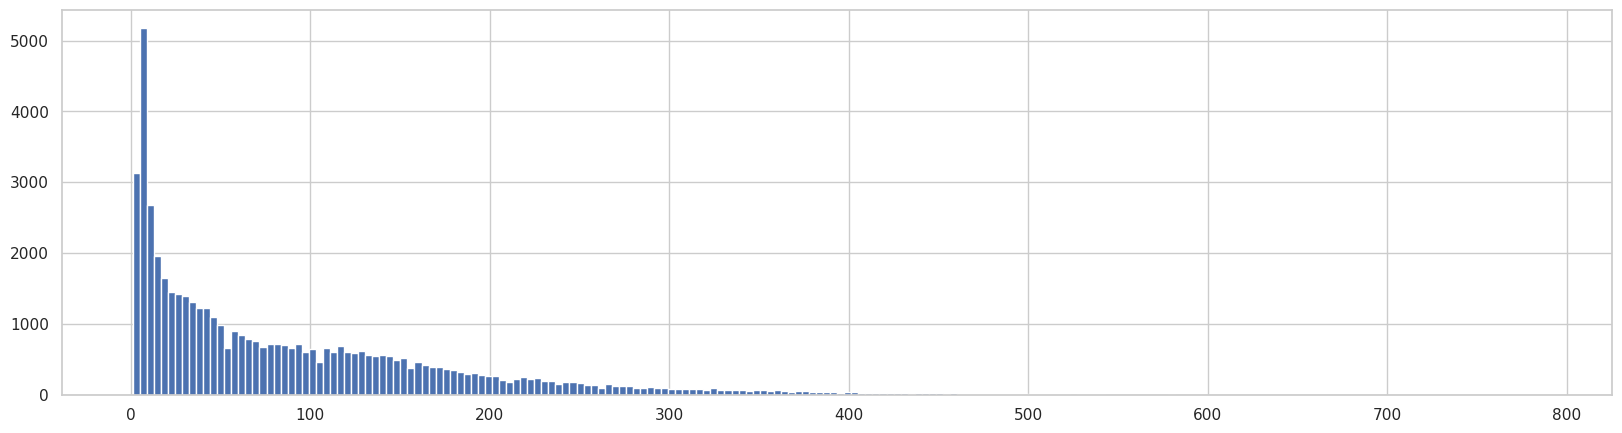

In [36]:
tmp_df = Mask_df.groupby('ID').size()

# Plot the distribution of the number of records for each patient
tmp_df.hist(bins=200, figsize=(20, 5))

In [37]:
tmp_df.describe()

count    51986.000000
mean        90.240449
std         93.903524
min          1.000000
25%         17.000000
50%         58.000000
75%        135.000000
max        786.000000
dtype: float64

In [38]:
ids_before = Mask_df.loc[Mask_df['Time'] < 1440].groupby('ID').size()
ids_after = Mask_df.loc[Mask_df['Time'] > 1440].groupby('ID').size()

In [39]:
ids_before_selected = ids_before.loc[ids_before >= 50].index
ids_after_selected = ids_after.loc[ids_after >= 50].index

print("ids_before_selected: ", ids_before_selected.shape)
print("ids_after_selected: ", ids_after_selected.shape)

ids_before_selected:  (19269,)
ids_after_selected:  (16441,)


<Axes: >

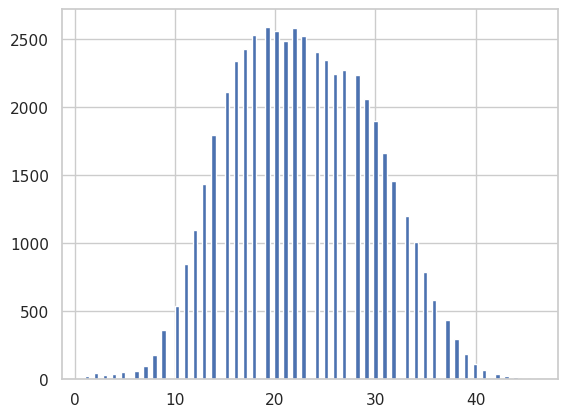

In [40]:
df_var_num = Mask_df.iloc[:, 1:].groupby("ID").apply(lambda x: x.sum(axis=0).gt(0).sum())
# Plot the distribution of the number of variables for each patient
df_var_num.hist(bins=100)

In [41]:
ids_selected_by_vars = df_var_num.loc[df_var_num >= 10].index

print("ids_selected_by_vars: ", ids_selected_by_vars.shape)

ids_selected_by_vars:  (51130,)


In [42]:
ids_selected = set(ids_before_selected) & set(ids_after_selected) & set(ids_selected_by_vars)
len(ids_selected)

11536

In [43]:
complete_df = complete_df.loc[list(ids_selected)]

In [44]:
complete_df.to_csv(
    path_m4/'processed/mimic4_data.csv')